In [ ]:
#library

In [1]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.models import load_model
from tensorflow.keras.models import load_model  as tf_load #for TCN
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm_notebook as tqdm
import time
from keras_layer_normalization import LayerNormalization
from tcn import TCN
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [ ]:
# produce data

In [2]:
df = pd.read_csv("london_merged.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

(17414, 13) (15673, 13) (1765, 13)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

  0%|          | 0/15649 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1741 [00:00<?, ?it/s]

Train size:
(15649, 24, 12) (15649,)
Test size:
(1741, 24, 12) (1741,)


In [ ]:
#import model

In [19]:
# lSTM-Daul
custom_ob = {'LayerNormalization': LayerNormalization}
LSTM_Daul_model = load_model('SINGLE_LSTM_model.h5', custom_objects=custom_ob)
print('lSTM-Daul loaded')
# Bi-LSTM-Daul
custom_ob = {'LayerNormalization': LayerNormalization}
Bi_LSTM_model = load_model('LSTM_model_4.h5', custom_objects=custom_ob)
print('Bi-LSTM-Daul loaded')
# GRU-Daul
custom_ob = {'LayerNormalization': LayerNormalization}
GRU_Daul_model = load_model('SINGLE_GRU_model.h5', custom_objects=custom_ob)
print('GRU-Daul loaded')
# Bi-GRU-Daul
custom_ob = {'LayerNormalization': LayerNormalization}
Bi_GRU_model = load_model('GRU_model_2.h5', custom_objects=custom_ob)
print('Bi-GRU-Daul loaded')
# TCN-Daul
custom_ob = {'TCN': TCN}
tcn_model = tf_load('TCN_model_1.h5', custom_objects=custom_ob)
print('TCN-Daul loaded')
# GRU-LSTM
custom_ob = {'LayerNormalization': LayerNormalization}
GRU_LSTM_model = load_model('GRU_LSTM_model.h5', custom_objects=custom_ob)
print('GRU-LSTM loaded')
# GRU-ATTENTION
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
GRU_ATTENTION_model = load_model('GRU_Single_Attention_model_NO_BI.h5', custom_objects=custom_ob)
print('GRU-ATTENTION loaded')
# BI-GRU-ATTENTION
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
BI_GRU_ATTENTION_model = load_model('GRU_Single_Attention_model_block.h5', custom_objects=custom_ob)
print('BI-GRU-ATTENTION loaded')

lSTM-Daul loaded
Bi-LSTM-Daul loaded
GRU-Daul loaded
Bi-GRU-Daul loaded
TCN-Daul loaded
GRU-LSTM loaded
GRU-ATTENTION loaded
BI-GRU-ATTENTION loaded


In [ ]:
# predict

In [21]:
def predict_model(Model,name,input_num):
    print('-----',name,'-----')
    t1 = time.time()
    
    if input_num == 2:
        y_pred = Model.predict([x_test,x_test])
    else:
        y_pred = Model.predict(x_test)
    
    y_pred = scaler.inverse_transform(y_pred)#Undo scaling   
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 =  r2_score(y_test, y_pred)
    print('RMSE: ',rmse)
    print('MAE: ',mae)
    print('R-square: ',r2)
    n = len(y_test)
    p = 12
    Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    print('Adj R-square: ',Adj_r2)
    t2 = time.time()
    print('Predict time: ',t2-t1)
    print('----------------')
    return y_pred
    
Bi_G_A = predict_model(BI_GRU_ATTENTION_model,'Bi-G-A',2)
G_A = predict_model(GRU_ATTENTION_model,'G-A',2)
G_L = predict_model(GRU_LSTM_model,'G-L',1)
T_CN = predict_model(tcn_model,'TCN',1)
Bi_L = predict_model(Bi_LSTM_model,'Bi-L',1)
Bi_G = predict_model(Bi_GRU_model,'Bi-G',1)
L_D = predict_model(LSTM_Daul_model,'L-D',1)
G_D = predict_model(GRU_Daul_model,'G-D',1)

print('ALL MODEL SUCCESS')

----- Bi-G-A -----
RMSE:  348.3202524400943
MAE:  234.5896298464929
R-square:  0.8594749589420626
Adj R-square:  0.8584990906013825
Predict time:  0.7255685329437256
----------------
----- G-A -----
RMSE:  357.41287771424805
MAE:  235.68519121637843
R-square:  0.85204261041727
Adj R-square:  0.8510151285451677
Predict time:  0.4261136054992676
----------------
----- G-L -----
RMSE:  431.3263613286872
MAE:  276.3863012849566
R-square:  0.7845193527739587
Adj R-square:  0.7830229593904445
Predict time:  0.35739922523498535
----------------
----- TCN -----
RMSE:  433.10437630690825
MAE:  234.10835370409427
R-square:  0.782739181107692
Adj R-square:  0.7812304254209399
Predict time:  0.2808535099029541
----------------
----- Bi-L -----
RMSE:  419.65933349677994
MAE:  261.4163729313254
R-square:  0.7960188475809017
Adj R-square:  0.7946023118002135
Predict time:  0.32505130767822266
----------------
----- Bi-G -----
RMSE:  412.87099333505495
MAE:  247.7056977317499
R-square:  0.802564605309

In [ ]:
#plot

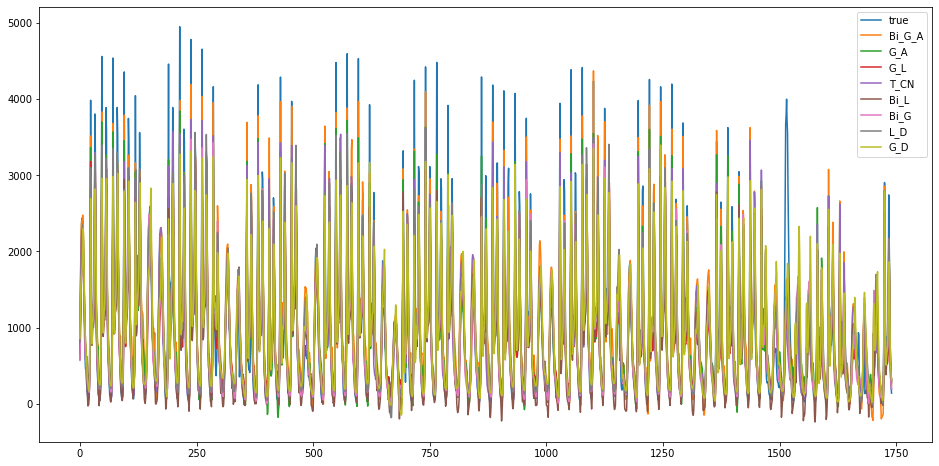

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(Bi_G_A, label='Bi_G_A')
plt.plot(G_A, label='G_A')
plt.plot(G_L, label='G_L')
plt.plot(T_CN, label='T_CN')
plt.plot(Bi_L, label='Bi_L')
plt.plot(Bi_G, label='Bi_G')
plt.plot(L_D, label='L_D')
plt.plot(G_D, label='G_D')
plt.legend()

1741


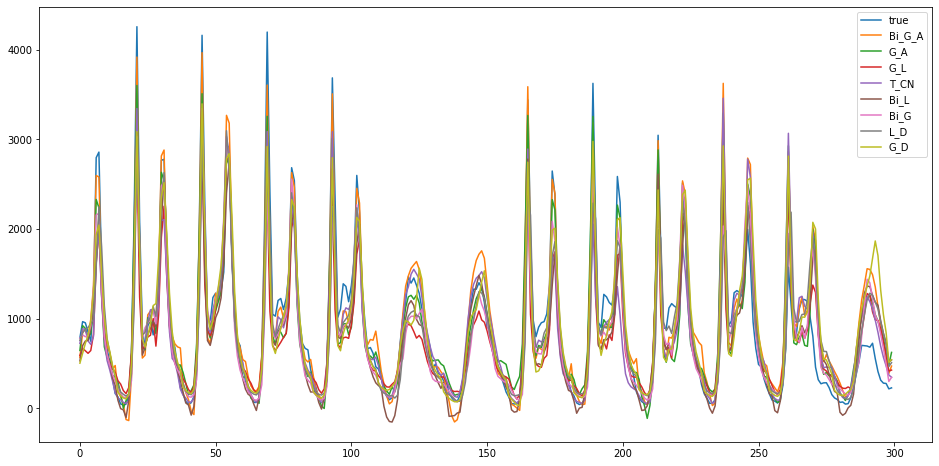

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1500], label='true')
plt.plot(Bi_G_A[1200:1500], label='Bi_G_A')
plt.plot(G_A[1200:1500], label='G_A')
plt.plot(G_L[1200:1500], label='G_L')
plt.plot(T_CN[1200:1500], label='T_CN')
plt.plot(Bi_L[1200:1500], label='Bi_L')
plt.plot(Bi_G[1200:1500], label='Bi_G')
plt.plot(L_D[1200:1500], label='L_D')
plt.plot(G_D[1200:1500], label='G_D')
plt.legend()
print(len(y_test))

In [ ]:
# xgb

In [33]:
from xgboost.sklearn import XGBRegressor
data = pd.read_csv("london_merged.csv")
# X = data.drop(['timestamp','cnt','t2'],axis=1)
X = data.drop(['timestamp','cnt'],axis=1)
y = data['cnt']

def df_split(df,train_percent):
    split_index = int(train_percent * len(df))
    train = df.iloc[:split_index+1]
    test = df.iloc[split_index+1:]
    return train,test

Xgb_train,Xgb_test = df_split(X,0.9)
y_xgb_train,y_xgb_test = df_split(y,0.9)

xgbmodel_fine = XGBRegressor(learning_rate= 0.046, n_estimators= 350, max_depth= 3, min_child_weight= 6, seed= 0,
                subsample= 0.6, colsample_bytree= 0.6, gamma= 0.08, reg_alpha= 3, reg_lambda= 0.1)
t1 = time.time()
xgbmodel_fine.fit(Xgb_train,y_xgb_train)
t2 = time.time()
print('Train time: ',t2-t1)

t1 = time.time()
preds = xgbmodel_fine.predict(Xgb_test)
rmse = np.sqrt(mean_squared_error(y_xgb_test, preds))
mae = mean_absolute_error(y_xgb_test, preds)   
r2 =  r2_score(y_xgb_test, preds)
print('RMSE: ',rmse)
print('MAE: ',mae)
print('R-square: ',r2)
n = len(y_test)
p = 12
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adj R-square: ',Adj_r2)
print(len(Xgb_test))
# plt.figure(figsize=(16,6))
# plt.plot(y_xgb_test,marker=".",label="actual",color="#eee8aa")
# plt.plot(preds,marker=".",label="prediction",color="#00bfff")
# plt.legend(['Ground truth', 'Predicted'])


Train time:  0.49566030502319336
RMSE:  893.3830082846708
MAE:  607.7701371667852
R-square:  0.07557508026369408
Adj R-square:  0.0691554627655252
1741


1741


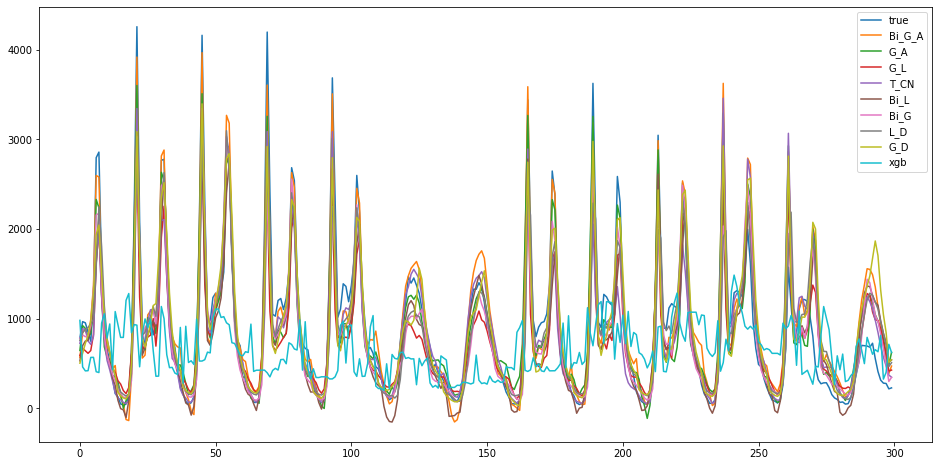

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1500], label='true')
plt.plot(Bi_G_A[1200:1500], label='Bi_G_A')
plt.plot(G_A[1200:1500], label='G_A')
plt.plot(G_L[1200:1500], label='G_L')
plt.plot(T_CN[1200:1500], label='T_CN')
plt.plot(Bi_L[1200:1500], label='Bi_L')
plt.plot(Bi_G[1200:1500], label='Bi_G')
plt.plot(L_D[1200:1500], label='L_D')
plt.plot(G_D[1200:1500], label='G_D')
plt.plot(preds[1200:1500], label='xgb')
plt.legend()

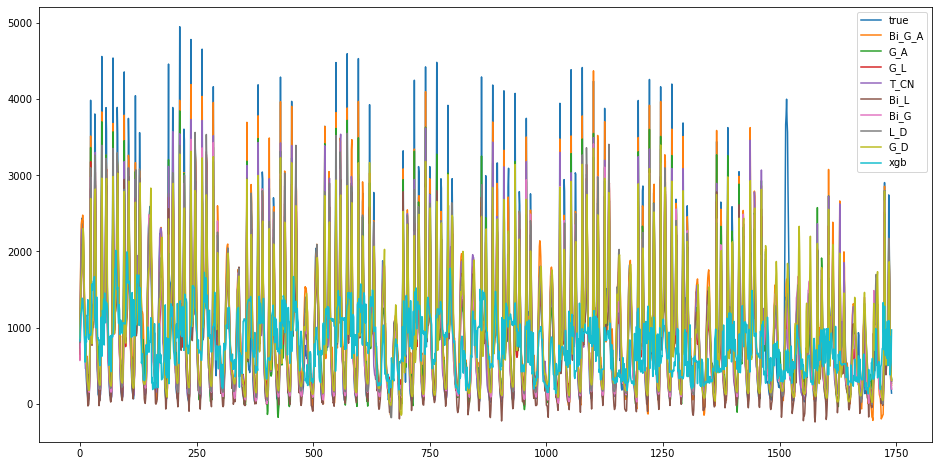

In [35]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(Bi_G_A, label='Bi_G_A')
plt.plot(G_A, label='G_A')
plt.plot(G_L, label='G_L')
plt.plot(T_CN, label='T_CN')
plt.plot(Bi_L, label='Bi_L')
plt.plot(Bi_G, label='Bi_G')
plt.plot(L_D, label='L_D')
plt.plot(G_D, label='G_D')
plt.plot(preds, label='xgb')
plt.legend()

In [ ]:
# prophet

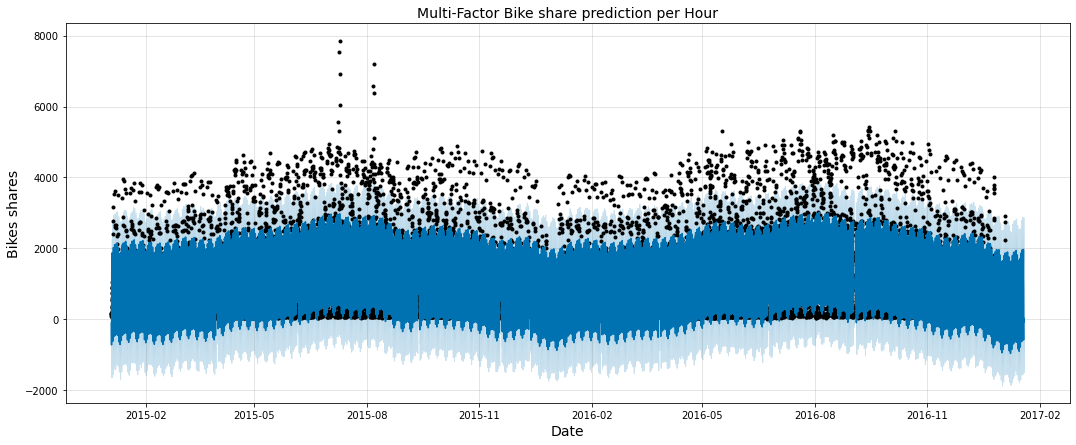

In [64]:
from fbprophet import Prophet
data = pd.read_csv("london_merged.csv")
feature_columns = [
    'weather_code',
    't1',
    'hum',
    'wind_speed',
    'is_holiday',
    'is_weekend',
    'season'
]
target_column = ['cnt']

multidata = data[['timestamp'] + target_column + feature_columns].copy()
multidata.columns = ['ds', 'y'] + feature_columns

multimodel = Prophet(daily_seasonality=True,changepoint_prior_scale=10)
# Fit the model with train set
multimodel.fit(multidata)
multifuture = multimodel.make_future_dataframe(periods=365, freq='H')
multi_hourpred = multimodel.predict(multifuture)
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

multimodel.plot(multi_hourpred, ax=ax)

ax.set_title('Multi-Factor Bike share prediction per Hour', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

In [65]:
min(multi_hourpred.yhat)

for i in range(len(multi_hourpred.yhat)):
    multi_hourpred.yhat[i]=multi_hourpred.yhat[i]+896.3196282628946
print('finish')

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


finish


17779
17414


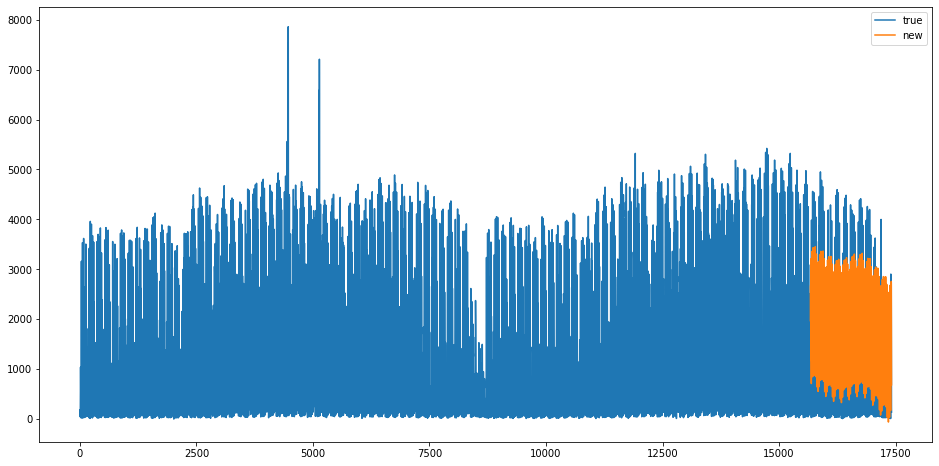

In [67]:
print(len(multi_hourpred.yhat))
print(len(multidata))

new = multi_hourpred.yhat[17414-1741:17414]
new
# multi_hourpred.to_csv("hourpred_df_new.csv")
new.to_csv("hourpred_df_new.csv")
plt.figure(figsize=(16, 8))
plt.plot(multidata.y, label='true')
plt.plot(new, label='new')
plt.legend()

In [68]:
data = pd.read_csv("hourpred_df_new.csv")
prophet_pred = data['yhat']
len(prophet_pred)

1741

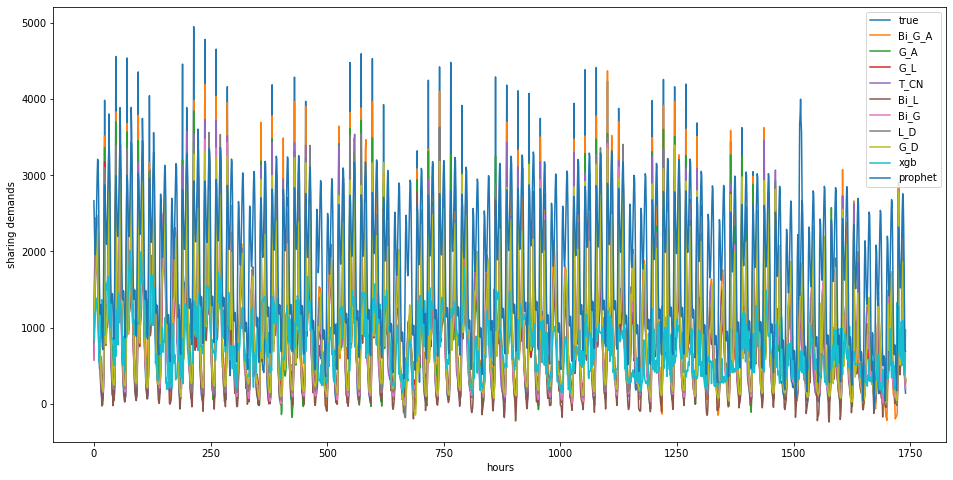

In [70]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(Bi_G_A, label='Bi_G_A')
plt.plot(G_A, label='G_A')
plt.plot(G_L, label='G_L')
plt.plot(T_CN, label='T_CN')
plt.plot(Bi_L, label='Bi_L')
plt.plot(Bi_G, label='Bi_G')
plt.plot(L_D, label='L_D')
plt.plot(G_D, label='G_D')
plt.plot(preds, label='xgb')
plt.plot(prophet_pred, label='prophet')
plt.legend()
plt.xlabel('hours')
plt.ylabel('sharing demands')
plt.savefig('All model compare.png')

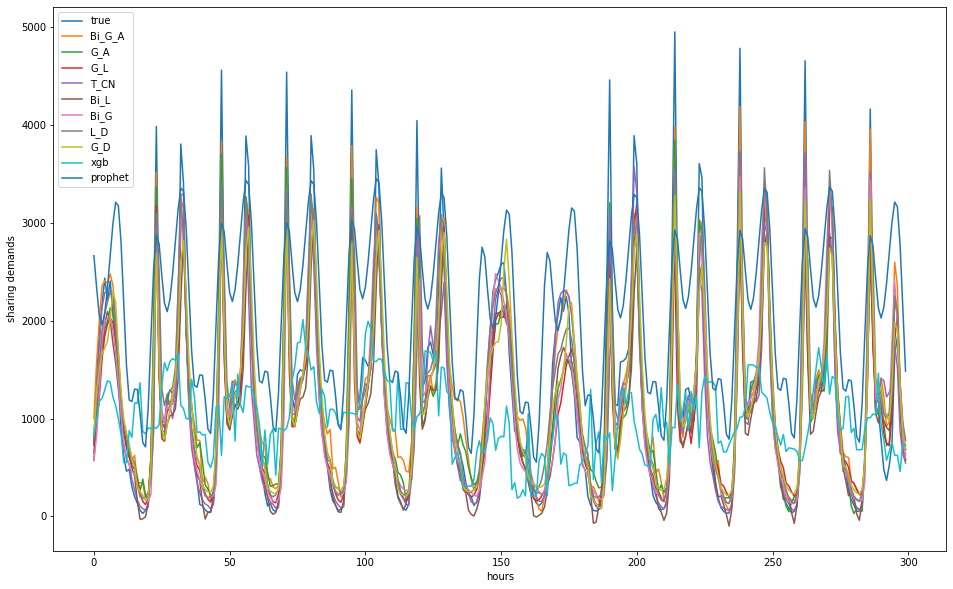

In [76]:
plt.figure(figsize=(16, 10))
plt.plot(y_test[0:300], label='true')
plt.plot(Bi_G_A[0:300], label='Bi_G_A')
plt.plot(G_A[0:300], label='G_A')
plt.plot(G_L[0:300], label='G_L')
plt.plot(T_CN[0:300], label='T_CN')
plt.plot(Bi_L[0:300], label='Bi_L')
plt.plot(Bi_G[0:300], label='Bi_G')
plt.plot(L_D[0:300], label='L_D')
plt.plot(G_D[0:300], label='G_D')
plt.plot(preds[0:300], label='xgb')
plt.plot(prophet_pred[0:300], label='prophet')
plt.legend(loc = 'best')
plt.xlabel('hours')
plt.ylabel('sharing demands')
plt.savefig('All model compare_300.png')

In [81]:
print(len(multi_hourpred.yhat))
print(len(multidata))

compare = multi_hourpred.yhat[15673:17414]
print(len(compare))
# multidata.head()
true = multidata.y[15673:17414]
rmse = np.sqrt(mean_squared_error(compare, true))
mae = mean_absolute_error(compare, true)
r2 =  r2_score(compare, true)    
print('RMSE: ',rmse)
print('MAE: ',mae)
print('R-square: ',r2)
n = len(y_test)
p = 12
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adj R-square: ',Adj_r2)

17779
17414
1741
RMSE:  1103.978539523452
MAE:  980.1552552357491
R-square:  -0.8558960480072804
Adj R-square:  -0.8687842150073308


In [83]:
data = pd.read_csv("london_merged.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])
mydata = data[['timestamp', 'cnt']].copy()
mydata["timestamp"] = pd.to_datetime(mydata["timestamp"])
mydata = mydata.set_index("timestamp")
# Daily resampling
daydata = mydata.resample("D").sum()

daydata['timestamp'] = daydata.index
daydata.index = range(0,len(daydata['cnt'].to_numpy()))

daydf = daydata[['timestamp','cnt']].copy()
daydf.columns = ['ds','y']
daymodel = Prophet(daily_seasonality=True,changepoint_prior_scale=10)
daymodel.fit(daydf) 
dayfuture = daymodel.make_future_dataframe(periods=365)
daypred = daymodel.predict(dayfuture)

In [87]:
print(len(daypred.yhat))
print(len(daydata))

compare = daypred.yhat[658:731]
print(len(compare))
daydata.head()

# multidata.head()
true = daydata.cnt[658:731]
rmse = np.sqrt(mean_squared_error(compare, true))
mae = mean_absolute_error(compare, true)
r2 =  r2_score(compare, true)    
print('RMSE: ',rmse)
print('MAE: ',mae)
print('R-square: ',r2)
n = len(y_test)
p = 12
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adj R-square: ',Adj_r2)


1096
731
73
RMSE:  4656.315997651269
MAE:  3271.619248486656
R-square:  0.14114368334504201
Adj R-square:  0.1351794033682715
